<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Tuesday 7 August 2018</td>
<td style="text-align: right;"><a href="https://github.com/douglask3/savanna_fire_feedback_test">github.com/douglask3/savanna_fire_feedback_test</td>
</tr>
</table>

<div>
<center>
<font face="Times">
<br>
<h1>Quantifying the uncertainity in climate potentials and mortality using Bayesian inference</h1>
<h2>Part 2: Bayesian inference</h2>
<br>
<br>
<sup>1,* </sup>Douglas Kelley, 
<sup>1 </sup>France Gerard, 
<sup>2 </sup>Rhys Whitley, 
<sup>3 </sup>Elmar Veenendaal
<br>
<br>
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<sup>3 </sup>Wageningen Univsersity, Wageningen UR
<br>
<br>
<h3>Summary</h3>
<hr>
<p> 
This notebook aims to quantify the model parameters of a global tree cover model model. Tree Cover is calculated as a product  precipitation, tempurature  and radiation controls describing large scale climate potetials, and mortality from fire, seasonal drought, tempuature and people, and exlusion from land use modulate tree cover. This limitation model for tree cover (LimTREE) is optimized using a Bayesian Inference framework, which provides a probability distribution for the models paramters, and allows us to describe the magnitude and relative impact of controls and varaibles in terms of probabilities. Here, we cover model description and optimization.
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

### Model description
Tree Cover ($T$) is calculated as a product five controls. Mean annual precipitation ($MAP$), mean annual tempurature ($MAT$) and incoming shortwave radiation ($SW$) represent three liberative controls on  $T$, i.e, increases in any of the variables lead to an increase in $T$. Mortality ($M$), which combines varaibles describing fire (represented by burnt area - $F$), drought (by number of dry days, $D$) and extreme seasonal tempuratures (by mean maximum temperuature of the hottest month, $MMxT$), and land use exclusion ($E$) from fractional urban ($U$), crop ($C$) and pasture ($P$) cover are suppresive controls. Each control is expressed as a linear combination of their respective variables and represented by a simple logistic curve:

\begin{equation}
    f(x) = \frac{1}{1 + e^{-k\cdot(x-x_0)}}
\end{equation}

\begin{eqnarray}
    T &=& F_{max} \cdot \prod f(x) \\[1em]
\end{eqnarray}

Where $f(x)$ is the limitation imposed by control $x = MAP, MAT, SW, M, E$ and $T_{max}$ is a maximum permitted monthly burnt area used to aid our model optimization. $x_0$ is the value of control $x$ when it imposes a limitation of 50\% on burnt area (i.e,$f(x) = 0.5$), and $k$ is the steepness of the logistic curve, equal to ¼ of the gradient at $x = x_0$. $k > 0$ for $MAP$, $MAT$ and $SW$, where $T$ increases with the control, whereas $k < 0$ for $M$ and $E$, for which $T$ decreases. Each suppresive control
is represented by a combination of variables ($x_i$) weighted by their respective influence ($v_i$). Where possible, units are consistent across variables within each control, and as such the combined variables are normalised to maintain these units:

\begin{eqnarray}
    x &=& \sum v_i \cdot x_i / \sum v_i  \\[1em]
\end{eqnarray}

\begin{eqnarray}
    v_i = 1
\end{eqnarray}



This leaves 14 free parameters that need to be optimised against observations of burnt area.

Now lets get this coded up in python

### Load libraries

In [29]:
import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import pymc3  as pm3 
from   pymc3.backends import SQLite
from   scipy  import optimize
from   theano import tensor as tt

import matplotlib.pyplot as plt

# setup nice plotting
plt.style.use('ggplot')
%matplotlib inline

# paths and parameters
sample_pc     = 10
nIterations   = 10000
outPath       = "../data/vegFracControls.csv"
param_outpath = '../outputs/params.csv'
trace_db      = '../data/vegmodel_trace10db'

In [30]:
def npLog0 (x):
    return [np.log(i) if i > 0 else 0.0000001 for i in x]

## 2.1 Fire limitation model definition

Could possibly contain this in a class object, but I'm not sure theano can instantiate the object to be used by the GPU. If I've made absolutely no sense just then, then I would leave the following as is.

In [31]:
from pdb import set_trace as browser
def MAP(map):
    """
    Definition to describe precip: while we are just returning input for now,
    we include climate potential functions for capability to be modified later.
    """
    return map

def MAT(mat):
    """
    Definition to describe temp.
    """
    return mat


def SW(sw1, sw2, d):
    """
    Definition to describe short wave
    """
    return sw1 + d * sw2 /(1.0 + d)


def mortality(fire, drought, maxTemp, pop_density, v_drought, v_maxTemp, v_pop,
            k_popden, n_drought, p_maxTemp):
    """
    Definition of mortality
    """
    
    maxTemp = maxTemp **(p_maxTemp)
    
    drought = drought
    pop_density = 1 - tt.exp(pop_density * (-1.0/ k_popden))
    mort = fire  +  v_drought * drought  +  v_maxTemp * maxTemp  +  v_pop * pop_density 

    return mort / (1.0 + v_drought + v_maxTemp + v_pop)

def exclusion(urban_area, crop_area, pasture_area, v_crop, v_pas):
    """
    Definition for the measure of fire supression
    """
    excl = urban_area  +  v_crop * crop_area + v_pas * pasture_area
    
    return excl / (1.0 + v_crop + v_pas)

def tt_sigmoid(x, k, x0):
    """
    Sigmoid function to describe limitation using tensor
    """
    return 1.0/(1.0 + tt.exp(-k*(x - x0)))


## 2.2 Import data

Load data and do any necessary transformation needed for the Bayesian modelling framework. We  going to load 10% of data-points. When we evalutate, that gives us 90% spare.

In [32]:
def load_with_buffer(filename, line_select, **kwargs):
    s_buf = StringIO()
    line_select = np.sort(line_select)
    with open(filename) as file:
        count = -1
        lineN = -1
        for line in file:
            lineN += 1
            if lineN == 0 or lineN == line_select[count]:
                s_buf.write(line)
                count += 1
                if count == len(line_select): break
            
    s_buf.seek(0)
    df = pd.read_csv(s_buf,**kwargs)
    return df

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f): pass
    return i + 1

DATAPATH = os.path.expanduser(outPath)

nlines      = file_len(DATAPATH)
npoints     = round(sample_pc * nlines / 100)
line_select = np.random.choice(range(0, nlines), npoints, False)
fd          = load_with_buffer(DATAPATH, line_select)

Do a sanity check to make sure our data has imported correctly.

In [33]:
print(fd.info())
print(fd.head())
fd.max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372 entries, 0 to 2371
Data columns (total 12 columns):
BurntArea    2372 non-null float64
crop         2372 non-null float64
Drought      2372 non-null float64
MAP          2372 non-null float64
MAT          2372 non-null float64
MTWM         2372 non-null float64
pas          2372 non-null float64
PopDen       2372 non-null float64
SW           2372 non-null float64
SW.1         2372 non-null float64
TreeCover    2372 non-null float64
urban        2372 non-null float64
dtypes: float64(12)
memory usage: 222.5 KB
None
   BurntArea      crop   Drought         MAP        MAT       MTWM       pas  \
0   0.001493  0.238247  0.459984   455.65000  22.379763  30.992857  0.268947   
1   0.010663  0.019304  0.501342   473.89285  14.117857  22.392857  0.090953   
2   0.000094  0.004171  0.439037   292.31427  19.039880  28.807142  0.622450   
3   0.018828  0.130236  0.100716  1696.65710  20.939880  28.671429  0.032139   
4   0.000000  0.000000  0

BurntArea       0.899582
crop            0.702210
Drought         1.000000
MAP          7731.857000
MAT            30.678572
MTWM           38.064285
pas             0.830334
PopDen       4778.423300
SW            415.134120
SW.1          353.578860
TreeCover       0.793839
urban           0.218199
dtype: float64

## 2.3 Baysian framework

A simple explanation of Baye's law is:

\begin{equation}
    P(\beta|X) \propto P(\beta)\cdot P(X|\beta)
\end{equation}

where $X$ is our data (observations of some arbitrary system), and $\beta$ our set of unexplained parameters that describe the reponse of our _proposed understanding_ of this system as it varies with $X$.

### 2.3.1 Prior definitions
Because I have no idea what the uncertainty on the hyper parameters should look like (beyond $\beta> 0$), I've set them all as wide, familiar distrubtions, spread generously beyound what is realistic plausable. Our full prior looks like this:

\begin{eqnarray}
    P(x_0) &=& \mathcal{N}(0.5, 0.5) \\
    P(k_x) &=& \mathcal{exp}(0.1) \\
    P(T_{max}) = P(p_{popden}) = P(v_i) &=& \mathcal{exp}(1) \\
    P(\sigma) &=& \mathcal{N_{1/2}}(1) \\[1.5em]
\end{eqnarray}

So our full set of piors looks something like this:

\begin{eqnarray}
    P(\beta) &=& \prod_{x=1}^{4}\mathcal{S}(P(x_0),P(k_x), P(v_x)) \cdot P(D_{max}) \cdot P(\sigma) \\[1.5em]  
\end{eqnarray}

This is loosly describes a (albeit slightly skewed) Normal distribution, so we can approximate our error ($\sigma$) with a normal distibution. 

Back to the code.., `pymc3` is quite funky in that it allows me to create an empty `Model()` object and just add things to it as I need them using a `with` statement. I've called our Bayesian model `tree_error` as that is what we are trying to Quantify.



In [34]:
with pm3.Model() as tree_error:
    
# first for the sigmoids  
    MAP_x0         = pm3.Exponential('MAP_x0'       ,  1/5000.0)
    MAP_k          = pm3.Exponential('MAP_k'        ,  1.0)
    
    MAT_x0         = pm3.Exponential('MAT_x0'   ,  1/25.0)
    MAT_k          = pm3.Exponential('MAT_k'    ,  1.0)
    
    #SW_x0          = pm3.Exponential('SW_x0'   ,  1/300.0)
    #SW_k           = pm3.Exponential('SW_k'    ,        1.5)
    
    mort_x0        = pm3.Normal('mort_x0', 0.5, 0.5)
    mort_k         = pm3.Exponential('mort_k' , 1.0)
    
    ex_x0          = pm3.Normal('ex_x0', 0.5, 0.5)
    ex_k           = pm3.Exponential('ex_k' , 1.0)
    
    max_T          = pm3.Exponential('max_T'         ,        1.0)
    #pow_f          = pm3.Uniform('pow_f'         ,     0.0,    1.0)
# now for the hyper-parameters that describe the independent fire condition covariates
    
    #cNpp = pm3.Uniform('cNPP', 0.0, 10)
    v_drought  = pm3.Exponential('v_drought', 1.0)
    v_maxTemp  = pm3.Exponential('v_maxTemp', 1.0)
    v_popDen   = pm3.Exponential('v_popDen' , 1.0)
    v_crop     = pm3.Exponential('v_crop'   , 1.0)
    v_pas      = pm3.Exponential('v_pas'    , 1.0)
    
    #trans_d    = pm3.Exponential('trans_d'  , 1.0)
    k_popden   = pm3.Exponential('k_popden' , 1.0)
    
    n_drought    = pm3.Exponential('n_drought', 1.0)
    min_maxTemp  = pm3.Normal     ('min_maxTemp', 20.0, 31.34)
    max_maxTemp  = pm3.Normal     ('max_maxTemp', 30.0, 31.34)
    p_maxTemp    = pm3.Exponential('p_maxTemp', 1.0)
# describe the standard deviation in the error term
    sigma      = pm3.HalfNormal('sigma', sd=1)

In [35]:
MAP_x0.tag.test_value

array(3465.73591232)

### 2.3.2 Likelihood definition

For the sake of simplicity (and because I don't really know any better), we define the model error as normally distributed (i.i.d.) although it most likely isn't. We could make this more complicated later by defining the error as heteroscedastic, but I wouldn't bother with that until we have some idea of the convergence. We're describing the error (observations minus model predictions) as follows:

\begin{eqnarray}
    P(X|\beta) &=& \mathcal{N}(F_{burn}, \sigma) \\[1em]
    \mathcal{N}(F_{burn}, \sigma) &=& \frac{N}{\sigma\sqrt{2\pi}}\exp\left\{\sum_{i=1}^{N}\left(\frac{y_i - F_{burn, i}}{\sigma_i}\right)^2\right\}
\end{eqnarray}

where $y_i$ is a set of observations we're attempting to optimise on. Below is the code that describes the above:

In [36]:
with tree_error:
     # transform hyper-covariates 
    f_precip = MAP(fd["MAP"].values)
    f_temp   = MAT(fd["MAT"].values)
    #f_sw     = SW (fd["SW"].values, fd["SW.1"].values, trans_d)
    f_mort   = mortality(fd["BurntArea"].values, fd["Drought"].values, fd["MTWM"].values, fd["PopDen"].values, 
                         v_drought, v_maxTemp, v_popDen, k_popden, n_drought, min_maxTemp, max_maxTemp, p_maxTemp)
    f_exc    = exclusion(fd["urban"].values, fd["crop"].values, fd["pas"].values, v_crop, v_pas)
    
    
    # Tree cover is assumed to be the product of the 4 sigmoid
    
    prediction = max_T * np.product([tt_sigmoid(f_precip, MAP_k, MAP_x0),
                             tt_sigmoid(f_temp, MAT_k, MAT_x0),
                             #tt_sigmoid(f_sw, SW_k, SW_x0),
                             tt_sigmoid(f_mort, - mort_k, mort_x0),
                             tt_sigmoid(f_exc, - ex_k, ex_x0)])
                  
    # calculate the error between observed and predicted burnt area
    error = pm3.Normal('error', mu = prediction, sd = sigma, observed=fd['TreeCover'].values)

### 2.3.3 Posterior sampling

Because it is nigh impossible to determine the posterior solution analytically we will instead sample the information space to **infer** the posterior solutions for each of the model parameters. In this case we are using a Metropolis-Hasting step MCMC.

I've tried using No-U-Turn (NUTS) sampling (which is the new kid on the block), but there are issues with it's current implementation in pymc3 (see github repo issues). Can use it once problems are ironed out - but TBH it doesn't matter if we're getting a reasonable convergence.

In [37]:
with tree_error:
    
    # help the sampling out by quickly finding an optimal start position
    #start = pm3.find_MAP(model=fire_error.model, fmin=optimize.fmin_powell)
    
    # set the step-method (criteria algorithm for moving around information space)
    step = pm3.Metropolis()
    
    # save our sampling to disk so we can access it later
    db_save = SQLite(trace_db)
    
    # do the sampling
    mcmc_traces = pm3.sample(nIterations, step=step, njobs= -1, trace=db_save)#, start=start

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma_log__]
>Metropolis: [p_maxTemp_log__]
>Metropolis: [max_maxTemp]
>Metropolis: [min_maxTemp]
>Metropolis: [n_drought_log__]
>Metropolis: [k_popden_log__]
>Metropolis: [v_pas_log__]
>Metropolis: [v_crop_log__]
>Metropolis: [v_popDen_log__]
>Metropolis: [v_maxTemp_log__]
>Metropolis: [v_drought_log__]
>Metropolis: [max_T_log__]
>Metropolis: [ex_k_log__]
>Metropolis: [ex_x0]
>Metropolis: [mort_k_log__]
>Metropolis: [mort_x0]
>Metropolis: [MAT_k_log__]
>Metropolis: [MAT_x0_log__]
>Metropolis: [MAP_k_log__]
>Metropolis: [MAP_x0_log__]
  0%|                                                                                        | 0/10500 [00:00<?, ?it/s]C:\Users\dougl\Anaconda3\lib\site-packages\pymc3\backends\sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(sel

ValueError: Chains are not unique.

## Reload

In [38]:
with tree_error:
    mcmc_traces = pm3.backends.sqlite.load(trace_db)

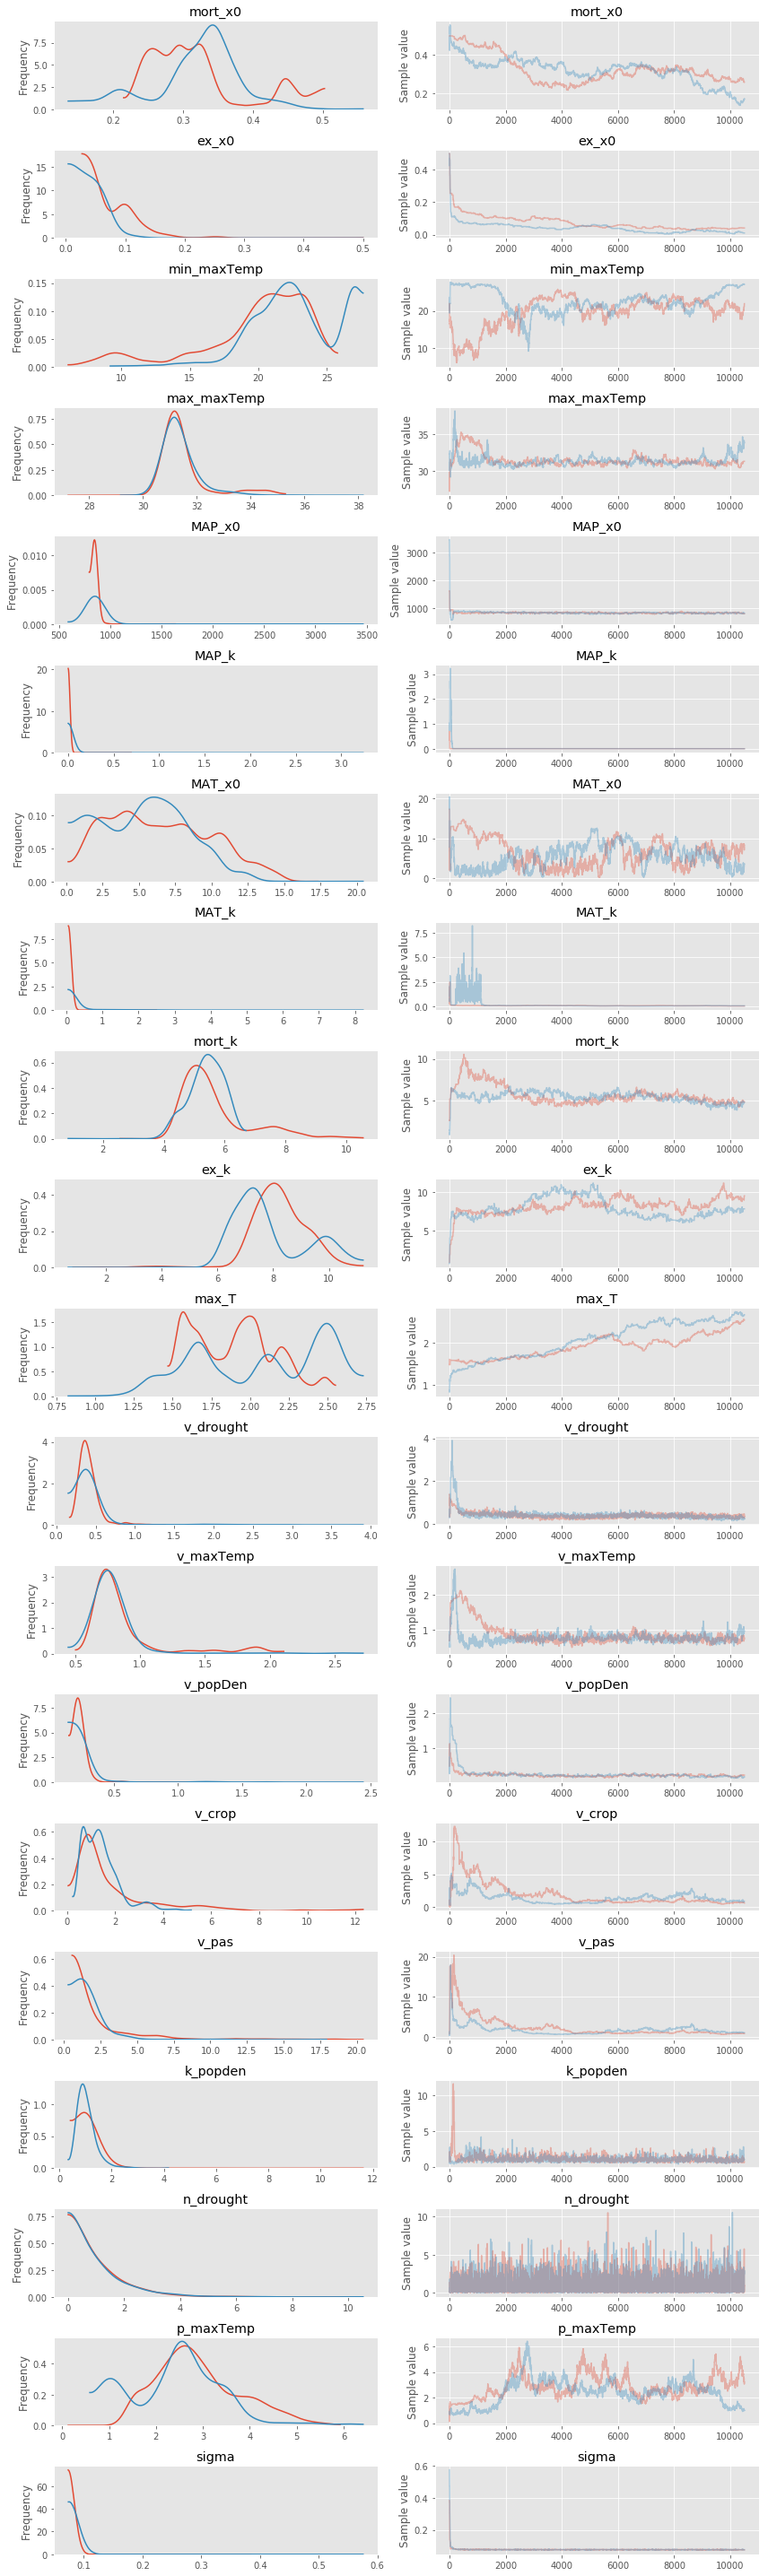

In [39]:
pm3.traceplot(mcmc_traces);

The iterations at the start are just letting the optimization settle. So we will only sample to last 5% of iterations for futher analysis. Here, exporting to netcdf for others to do their own analysis

In [41]:
varnames = mcmc_traces.varnames

def cutFirstX(varname, ncut = 80):           
    vals = mcmc_traces.get_values(varname)
    ncut = round(len(vals) * ncut / 100)
    vals = vals[ncut:]
    return(vals)

vals = [cutFirstX(i) for i in varnames]
vals = pd.DataFrame(np.array(vals).T, columns=varnames)
vals.to_csv(param_outpath, index=False)

vals.head()

,MAP_x0_log__,MAP_k_log__,MAT_x0_log__,MAT_k_log__,mort_x0,mort_k_log__,ex_x0,ex_k_log__,max_T_log__,v_drought_log__,...,max_T,v_drought,v_maxTemp,v_popDen,v_crop,v_pas,k_popden,n_drought,p_maxTemp,sigma
0,6.743421,-5.628363,2.369622,-2.738659,0.332773,1.779274,0.025139,1.995549,0.858354,-1.115485,...,2.359275,0.327756,0.717188,0.202891,1.11194,1.180963,0.624042,0.232116,2.389890,0.075588
1,6.743421,-5.628363,2.369622,-2.738659,0.332773,1.779274,0.025139,1.995549,0.858354,-1.115485,...,2.359275,0.327756,0.717188,0.202891,1.11194,1.180963,0.644075,0.281234,2.389890,0.075588
2,6.743421,-5.628363,2.369622,-2.776036,0.332773,1.779274,0.025139,1.995549,0.858354,-0.974992,...,2.359275,0.377195,0.717188,0.202891,1.11194,1.180963,1.093439,3.242667,2.389890,0.075588
3,6.743421,-5.628363,2.322332,-2.776036,0.332773,1.779274,0.025139,1.995549,0.858354,-0.974992,...,2.359275,0.377195,0.705264,0.202891,1.11194,1.180963,1.036319,3.242667,2.389890,0.075588
4,6.743421,-5.628363,2.322332,-2.776036,0.332773,1.779274,0.025139,1.995549,0.864515,-0.974992,...,2.373855,0.377195,0.705264,0.202891,1.11194,1.180963,1.036319,0.311947,2.228656,0.074696


## Plotting

Let look at the pdf of the last 5% of iterations for each parameter

In [ ]:
variables2Plot = ['fuel_x0'       , 'fuel_k',
                  'moisture_x0'   , 'moisture_k',
                  'igntions_x0'   , 'igntions_k',
                  'suppression_x0', 'suppression_k',
                  'fuel_pw'       , 'fuel_pg',
                  'cM'            , 'cMT',
                  'cC'            ,
                  'cP1'           , 'cP2', 
                  'cD1'           , 'cD2', 'max_f']

nvar = len(variables2Plot)
npcol = 4
nprow = np.ceil(nvar / npcol)

plt.figure(figsize=(20,5 * nprow))
def plotVar(var1, pn):
    plt.subplot(npcol, nprow, pn)
    param = vals[var1]
    
    hist, bins = np.histogram(param, bins=50)
    hist = 100.0 * hist / np.sum(hist)
    bins = bins[1:] - np.diff(bins)/2
    plt.plot(bins, hist)
    plt.xlabel(var1)
    
pn = 0
for i in variables2Plot:
    pn = pn + 1
    plotVar(i, pn)

And what to the sigmoids look like?

In [ ]:
from pdb import set_trace as browser

def pltVsFire(x, xlab, pnt = 'o', *args, **kw):
    plt.plot(x, fd.fire, pnt, alpha = 0.03, *args, **kw)
    plt.xlabel(xlab)
    
def np_sigmoid(x, k, x0):
    """
    Sigmoid function to describe limitation using tensor
    """
    return 1.0/(1.0 + np.exp(-k*(x - x0)))

def returnSigmoid(x, k, x0):
    return np_sigmoid(x, k, x0)
    
def meanParam(x, x0, k, kmult = 1.0):
    x0 = np.mean(vals[x0])
    k  = np.mean(vals[k]) * kmult

    return returnSigmoid(x, k, x0)

def randomParam(x, x0, k, kmult = 1.0, size = 100):
    ps = np.random.choice(vals.shape[0], size = size, replace = False)
    return [returnSigmoid(x, vals[k][i] * kmult, vals[x0][i]) for i in ps]

In [ ]:
plt.figure(figsize=(10, 10))

####################
## Fuel           ##
####################
plt.subplot(2, 2, 1)
## scatter plot
fp = np.mean(vals['fuel_pw'])
fg = np.mean(vals['fuel_pg'])
cNPP = 1.0#np.mean(vals['cNPP'])

f_fuel = fuel_load(fd["vegCover"].values, fd["alphaMax"].values, fp, fg)
print(f_fuel.max())
pltVsFire(f_fuel, "NPP (g/m$^2$)", 'go')

## Line of best fit
#Fuel = np.arange(-6, fd.fuel.max(), 0.01)
Fuel = np.arange(0, f_fuel.max(), 0.01)
r_fuel = randomParam(Fuel, 'fuel_x0', 'fuel_k')
#NPP = np.exp(Fuel)
for r in r_fuel: plt.plot(Fuel, r, 'k', alpha=.01)

## cfg plot
#plt.xscale('log')
#plt.xlim([0.5, fd.NPP.max()])

####################
## Moisture       ##
####################
plt.subplot(2, 2, 2)
## scatter plot
Fmax = np.mean(vals['max_f'])
cM = np.mean(vals['cM'])
cMT = np.mean(vals['cMT'])
f_moisture = moisture(fd["alpha"].values, fd["emc"].values, fd["treecover"].values, cM, cMT)
pltVsFire(f_moisture , "Moisture = $\\alpha$ + M $\cdot$ EMC",'bo')

## Line of best fit
mst = np.arange(0.0, f_moisture.max(), 0.05)
r_moisture = randomParam(mst, 'moisture_x0', 'moisture_k', -1.0)
for r in r_moisture: plt.plot(mst, r, 'k', alpha=.01)

    
plt.ylim(0, 1)

####################
## Igntions       ##
####################
plt.subplot(2, 2, 3)
## scatter plot 
cP  = np.mean(vals['cP1'])
cC  = np.mean(vals['cC' ])
cD1 = np.mean(vals['cD1'])
igniteMax = 10

f_ignite = ignition(fd["lightning_ignitions"].values, \
                    fd["cropland"].values, \
                    fd["pasture"].values, \
                    fd["population_density"].values, \
                    cC, cP, cD1)
#f_ignite = np.exp(f_ignite)
pltVsFire(f_ignite, "Ignitions events = Lightn + P $\cdot$ Pop Dens + D1 $\cdot$ Pasture")

## Line of best fit
Ignite = np.arange(0.0, igniteMax, 0.1)
#Ignite = np.exp(Ignite)
#=Ignite = np.arange(0.0, 10000, 1)
r_Ignite = randomParam(Ignite, 'igntions_x0', 'igntions_k')
#yay = returnSigmoid(Ignite, 10, 1.0)
#Ignite = np.exp(Ignite)
for r in r_Ignite: plt.plot(Ignite, r, 'k', alpha=.01)

#plt.plot(Ignite, yay, 'red')

    
## cfg plot
#plt.xscale('log')
plt.xlim(0, igniteMax)

####################
## Suppression    ##
####################
plt.subplot(2, 2, 4)
#scatter plot
cP2 = np.mean(vals['cP2'])
cD2 = np.mean(vals['cD2'])
maxF = np.mean(vals['max_f'])
f_suppression = maxF * supression(fd["cropland"].values, \
                           fd["cropland"].values, \
                           fd["population_density"].values, \
                           cP2,
                           cD2)

pltVsFire(f_suppression, "Suppression = Cropland + D2 $\cdot$ Pop den")

# Line of best fit
Suppress = np.arange(0, 100, 0.01)
r_suppression = randomParam(Suppress, 'suppression_x0', 'suppression_k', -1.0)
for r in r_suppression: plt.plot(Suppress, r * Fmax, 'k', alpha=.01)

plt.xlim(0, 100)
plt.ylim(0, 1)